
![GDP Map](https://upload.wikimedia.org/wikipedia/commons/2/27/Countries_by_Human_Development_Index_%282020%29.png)


<div>
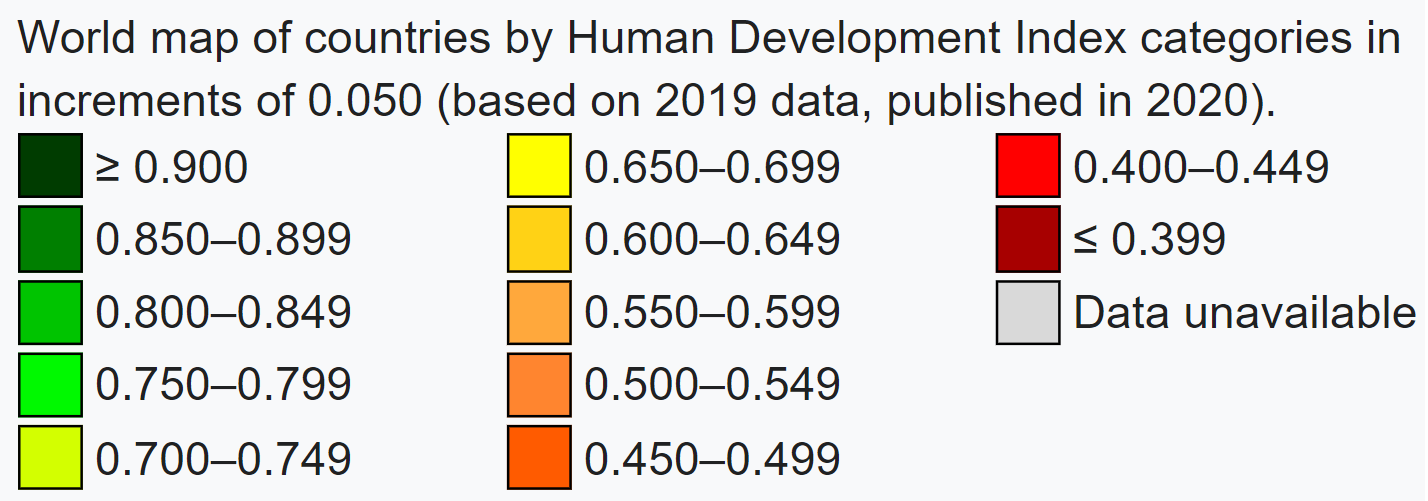
</div>

  ### **0. Outline**
  #### **1. Introduction**
  #### **2. Methods**
  #####                  Wikipedia Scraping
  #####      Data Cleaning
  #####      Data Visualization
  #### **3. Data Analysis**

  ### **1. Introduction**
  
     This capstone project has my own designed script that takes in a Wikipedia link and returns the tables of that specific Wikipedia page is csv format. The data tables will be cleaned using pandas. Pandas will also be used to analyze the data and matplotlib will be used to display the data in plot. A front-end website was built using HTML and CSS to display results.
     Human Development Index (HDI) is a statistical composite index that measures life expectancy at birth (life expectancy index), expected years of schooling/mean years of schooling (education index), and Gross National Income(GNI) (GNI per capita index in dollars). GNI is the total domestic and foreign output claimed by residents of a country. HDI is sometimes viewed as the index of 'potential' human development. Inequality-adjusted human development index (IHDI) on the other hand takes into account economic inequalitywhen caluculating HDI and is sometimes viewed as the index of 'actual' human development.
     HDI will be compared to the world happiness report, gender inequality index, and social progress index. The goal of this project is to find which report/index more closely correlates with the HDI index. The world happiness report is a report that measures happiness based on respondent ratings in their own lives.Gender inequality index is a composite measure to quantify the loss of achievement within a country due to gender inequality.Social progress index measures the extent to which countries provide for the social and environmental needs of its citizens. The social and environmental factors include wellness (including health, shelter and sanitation), equality, inclusion, sustainability and personal freedom and safety. The following will answer how is development (HDI) affect happiness, gender inequality, and social progress. Provided correlation is related to causation. 
     

### **2. Methods**

#### **Wikipedia Scraping**
#### a. 
    Imports, wikipedia URL, paths, and script to create saving directory to avoid making folders each time were coded into the script. 

In [14]:
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

url ='https://en.wikipedia.org/wiki/List_of_countries_by_GNI_(nominal)_per_capita'

page = requests.get(url)


### FILL OUT BELOW ###
soup = BeautifulSoup(page.content, 'html.parser')

doc_title= 'GNI_(nominal)_per_capita'

path_dir = r'C:\Users\alebe\Documents\coding-temple-jan2021\capstone\csv_tables'

### FILL OUT ABOVE ###
path_join = os.path.join(path_dir, doc_title)
try: 
    path = os.makedirs(path_join)
except OSError as error:  
    print(error)   

#### b. 
    Tables were located in provided wikipedia html by tags and class and were stored for further use in the script.

In [15]:
def locate_tables(soup=soup, tag="table", class_type="class", class_value="wikitable"):
    tbody_class_tables_dict = {}
    wikitable_sortable_class = soup.find_all(tag, {class_type : class_value})
    for i, wiki_table in enumerate(wikitable_sortable_class):
        tbody_class_tables_dict[f'Table_{i + 1}'] = wikitable_sortable_class[i]
            
    return tbody_class_tables_dict

tbody_class_tables_dict = locate_tables(soup, "table", "class", "wikitable")

#### c. 
    Tables were filtered using regex from characters not needed while keeping characters to further separate cells.

In [16]:
def removed_tag_tables(soup=soup, tag= '', regex = ''):
    import re
    text_corpus = soup.find_all(tag) 
    final_text = []
    
    if type(regex) == str:
        regex_in = regex
    elif type(regex) == list:
        regex_in = '|'.join(regex)
    else:
        raise ValueError('Use only a regex string or list of regex strings')

    for node in text_corpus:
        text = node.get_text()
        text= re.sub(regex_in, '', text)
        final_text.append(text)
    return final_text


def filter_tables(tables_dict):        
    filtered_table_dict = {}
    for key, val in tables_dict.items():
        tbody_class_table_clean = removed_tag_tables(val, 'tr' , ["\[[^\]]*\]", '\xa0', ',', '\n$', '^\n', '\xad', '\u200b', '\u0394'])
        filtered_table_dict[key] = tbody_class_table_clean        


    return filtered_table_dict

filter_tables_dict = filter_tables(tbody_class_tables_dict)


#### d. 
    Empty cells ere filled with Nulls (NaN). Sometimes nulls have to be added in different ways as seen in the commented out lines.

In [17]:
def fill_nulls(tables_dict):
    #print(tables_dict)
    
    import numpy as np
    filled_filter_tables_dict = {}
    for key, table in tables_dict.items():
        filled_nulls_table = []
        for i, row in enumerate(table):
#             while '\n\n\n' in row:
#                 row = row.replace('\n\n\n', '\nNaN\n')
#             while '\n\n' in row:
#                 row = row.replace('\n\n', '\nNaN\n')
            if '\n' in row[0:1]:
                row_filled = 'NaN' + row     
            if '\n' in row[-2:]:
                row_filled = row+'NaN' 
                filled_nulls_table.append(row_filled)
            else:
                row_filled = row
                filled_nulls_table.append(row_filled)
        filled_filter_tables_dict[key] = filled_nulls_table
    return filled_filter_tables_dict
    
filtered_tables_rows = fill_nulls(filter_tables_dict)

#### e. 
    Rows for the tables were created in list form per row of the tables

In [18]:
def make_tables(tables_dict):
    import re   
    final_tables_dict = {}
    for key, table in tables_dict.items():
        filtered_tables_rows_dict = {}
        for i, val in enumerate(table, 1):
            row = re.split(r"\n", val)
            while "" in row:
                row.remove("")
            filtered_tables_rows_dict[f'Row_{i}'] = row

        final_tables_dict[key] = filtered_tables_rows_dict
    return final_tables_dict
    
final_rows = make_tables(filtered_tables_rows)

#### f. 
    Pandas dataframe was created. The tables with the mode number of values in the list were added to one dictionary. If the table rows did not have the same number of values in the list as the mode then they would be saved in a different dictionary. Some wikipedia tables have rows with different number of cells. A data frame must always have the same number of cells in each row.

In [19]:
def make_dataframe(tables_dict):
    tables_to_df = {}
    removed_tables= {}
    for table_key, table in tables_dict.items():
        same = True
        len_avg = []
        for i in range(len(table.values()) - 1):
            length = len(list(table.values())[i])
            len_avg.append(length)
            if len(list(table.values())[i+1]) == length:
#                 print(f'good: {list(table.values())[i], list(table.values())[i+1]}')
                pass
            else:
#                 print(f'bad: {list(table.values())[i], list(table.values())[i+1]}')
                same = False
        if same == True:
            tables_to_df[table_key] = table
        else:
            keep_rows = input(f'{table_key} could not be added, would you like to add the table with missing values?(y/n) \n')
            while keep_rows.lower() not in ["yes", "y", "no", "n"]:
                keep_rows = input(f'Sorry, "{keep_rows}" is not a valid input.\nTable {table_key} could not be added, would you like to add the table with missing values?(y/n)')
            if keep_rows.lower() == "no" or keep_rows.lower() == "n":
                print(f'{table_key} was not be added, the length of the rows are not the same')
                same = True
            elif keep_rows.lower() == "yes" or keep_rows.lower() == "y":
                mode = max(set(len_avg), key=len_avg.count)
                
                tables_to_df[table_key] = {}
                removed_tables[table_key] = {}
                for row_key, row in table.items():
                    length = len(row)
                    if len(row) == mode:
                        tables_to_df[table_key][row_key] = row
                    else:
                        print(f'Popped key:{row_key} and pop value: {row}')
                        removed_tables[table_key][row_key] = row
    final_tables = {}
    for key, table in tables_to_df.items():
        final_tables[key] = pd.DataFrame.from_dict(table).transpose()
        final_tables[key] = final_tables.get(key).reset_index(drop = True)
        final_tables[key].columns = final_tables[key].iloc[0]
        final_tables[key] = final_tables[key][1:]
    return final_tables, removed_tables

final_tables_tup = make_dataframe(final_rows)
final_tables = final_tables_tup[0]
removed_tables = final_tables_tup[1]

#### g. 
    Dataframes were saved to the original path made at the begining of the script. Each table is it's own csv. The removed valuesfor each table were saved as list of rows in txt files.

In [20]:
def finaldf_to_csv(final_df):
    for i, table in enumerate(final_df): 
        final_df[table].to_csv(path_dir+'/'+doc_title+'/'+doc_title+'_'+str(table)+'.csv')
        print(f'Table_{i + 1} was saved in CSV format!')
finaldf_to_csv(final_tables)


def removeddf_to_csv(removed_tables):
    if removed_tables != {}: 
        for table in removed_tables:
            with open(path_dir+'/'+doc_title+'/'+doc_title+'_'+str(table)+'.txt', 'w') as output:
                for key, row in removed_tables[f'{table}'].items():
                    output.write(f"table:{str(table)}, row number:{str(key)}, row content: {str(row)}" + '\n')
                print(doc_title+f' was saved in a TXT format! {table}')

removeddf_to_csv(removed_tables)

Table_1 was saved in CSV format!
Table_2 was saved in CSV format!
Table_3 was saved in CSV format!
Table_4 was saved in CSV format!
Table_5 was saved in CSV format!
Table_6 was saved in CSV format!
Table_7 was saved in CSV format!
Table_8 was saved in CSV format!
Table_9 was saved in CSV format!


#### **Data Cleaning**
#### a. 
    Start with imports. Pandas and numpy were used for data cleaning. Pycountry_convert was used for missing data. Matplotlib and seaborn for visualization.

In [21]:
import pandas as pd
import numpy as np
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns


#### b.
    The DataFrames were uploaded under their respective names. Some columns were removed, some column names were changed, and some country names were changed to merge the data.
    

In [27]:
# Inequality Human Development Index (IHDI)
ihdi = pd.read_csv('csv_final_project/Inequality-Adjusted_HDI/Inequality_Adjusted_HDI_(IHDI)_(2020 report).csv', sep = ',').iloc[:, 1:]
ihdi_condensed = ihdi.rename(columns={'Rank':'HDI_Rank'}, inplace=True)
ihdi_condensed = ihdi[['Country', 'IHDI', 'HDI', 'HDI_Rank']]

ihdi_condensed['Country'].replace(['Rep. of the Congo', 'Dem. Rep. of the Congo', 'North Macedonia'],['Republic of the Congo', 'Democratic Republic of the Congo', 'Republic of North Macedonia'])


# Gender Inequality Index (GII)
gii = pd.read_csv('csv_final_project/Gender_Inequality_Index/Gender_Inequality_Index_2019.csv', sep = ',').iloc[:, 1:]
gii.rename(columns={'GII Rank':'GII_Rank', 'GII Value': 'GII_Value'}, inplace=True)
gii_condensed = gii[['Country', 'GII_Value', 'GII_Rank']]

gii_condensed['Country'].replace(['Syrian Arab Republic', 'Viet Nam', 'Macedonia', 'Russian Federation', 'Czechia'],['Syria', 'Vietnam', 'Republic of North Macedonia', 'Russia', 'Czech Republic'])


#Social Progress Index (SPI)
spi = pd.read_csv('csv_final_project/Social_Progress_Index/Social_Progress_Index_2020_report.csv', sep = ',').iloc[:, 1:]
spi.rename(columns={'Rank':'SPI_Rank', 'Score': 'SPI_Score'}, inplace=True)
spi_condensed = spi[['Country', 'SPI_Score', 'SPI_Rank']]

spi_condensed['Country'].replace(['Congo Republic of', 'Congo Democratic Republic of', "Cote D'Ivoire", 'Gambia The'],['Republic of the Congo', 'Democratic Republic of the Congo', "Côte d'Ivoire", 'Gambia'])

#World Happiness Report (WHR)
whr = pd.read_csv('csv_final_project/World_Happiness_Report/World_Happiness_Report_2020(2017-2019avg).csv', sep = ',').iloc[:, 1:]
whr.rename(columns={'Overall rank':'WHR_Rank', 'Country or region':'Country', 'Score':'WHR_Score'}, inplace=True)
whr_condensed = whr[['Country', 'WHR_Score', 'WHR_Rank']]

whr_condensed['Country'].replace(['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Ivory Coast', 'Macedonia'],['Republic of the Congo', 'Democratic Republic of the Congo',"Côte d'Ivoire", 'Republic of North Macedonia'])


ihdi

,HDI_Rank,Country,IHDI,HDI,Overall loss (%),Growth since 2010
0,1,Norway,0.899,0.957,6.1,0.021
1,2,Iceland,0.894,0.949,5.8,0.055
2,3,Switzerland,0.889,0.955,6.9,0.015
3,4,Finland,0.888,0.938,5.3,0.040
4,5,Ireland,0.885,0.955,7.3,0.066
...,...,...,...,...,...,...
148,148,Mali,0.289,0.434,33.4,0.037
149,149,Niger,0.284,0.394,27.9,0.065
150,150,South Sudan,0.276,0.433,36.3,NaN
151,151,Chad,0.248,0.398,37.7,0.024


#### c.
    Row "world" was removed from the IHDI DataFrame since it is not a country.

In [28]:
### RUN ONLY ONCE ###
ihdi_condensed = ihdi_condensed.drop(83)
ihdi_condensed = ihdi_condensed.reset_index(drop = True)
### RUN ONLY ONCE ###


#### d.
    All four previous tables were joined and 'NaN' values were replaced with np.nan values. Column data types were changed to better represent the rows and columns were reorganized.

In [29]:
pd.options.display.max_rows = 10
joined_table = ihdi_condensed.merge(gii_condensed, on = 'Country', how = 'outer')
joined_table = joined_table.drop_duplicates(subset = 'Country').reset_index(drop = True)

joined_table = joined_table.merge(spi_condensed, on = 'Country', how = 'outer')
joined_table = joined_table.drop_duplicates(subset = 'Country').reset_index(drop = True)

joined_table = joined_table.merge(whr_condensed, on = 'Country', how = 'outer')
joined_table = joined_table.drop_duplicates(subset = 'Country').reset_index(drop = True)

joined_table = joined_table.replace(float("NaN"), np.nan)
joined_table = joined_table.dropna(how='any').reset_index(drop = True)
joined_table = joined_table.astype({'HDI_Rank': 'int64', 'SPI_Rank': 'int64', 'GII_Rank': 'int64', 'WHR_Rank': 'int64', 'HDI': 'float', 'IHDI': 'float', 'SPI_Score': 'float', 'GII_Value': 'float', 'WHR_Score': 'float'})

main_table = joined_table[['Country',  'HDI_Rank', 'SPI_Rank', 'GII_Rank', 'WHR_Rank', 'HDI', 'IHDI', 'SPI_Score', 'GII_Value', 'WHR_Score']]

main_table

,Country,HDI_Rank,SPI_Rank,GII_Rank,WHR_Rank,HDI,IHDI,SPI_Score,GII_Value,WHR_Score
0,Norway,1,1,6,5,0.957,0.899,92.73,0.045,7.488
1,Iceland,2,9,9,4,0.949,0.894,91.09,0.058,7.504
2,Switzerland,3,6,1,3,0.955,0.889,91.42,0.025,7.560
3,Finland,4,3,7,1,0.938,0.888,91.89,0.047,7.809
4,Ireland,5,12,23,16,0.955,0.885,90.35,0.093,7.094
...,...,...,...,...,...,...,...,...,...,...
113,Sierra Leone,147,134,155,139,0.452,0.291,51.74,0.644,3.926
114,Mali,148,150,158,114,0.434,0.289,48.29,0.671,4.729
115,Niger,149,157,154,103,0.394,0.284,42.21,0.642,4.910
116,Chad,151,162,160,127,0.398,0.248,31.29,0.710,4.423


#### e.
    The package country_alpha2_to_continent_code was installed to further visualize each country by continent.A new continent column was added.

In [30]:
main_table_nonull = main_table.dropna(how='any')

continent_list = []
for i, country in enumerate(main_table_nonull['Country']):
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    continent_list.append(continent_name)
    
main_table_nonull.insert(loc=1, column="Continent", value=continent_list) 
data = main_table_nonull

data

,Country,Continent,HDI_Rank,SPI_Rank,GII_Rank,WHR_Rank,HDI,IHDI,SPI_Score,GII_Value,WHR_Score
0,Norway,Europe,1,1,6,5,0.957,0.899,92.73,0.045,7.488
1,Iceland,Europe,2,9,9,4,0.949,0.894,91.09,0.058,7.504
2,Switzerland,Europe,3,6,1,3,0.955,0.889,91.42,0.025,7.560
3,Finland,Europe,4,3,7,1,0.938,0.888,91.89,0.047,7.809
4,Ireland,Europe,5,12,23,16,0.955,0.885,90.35,0.093,7.094
...,...,...,...,...,...,...,...,...,...,...,...
113,Sierra Leone,Africa,147,134,155,139,0.452,0.291,51.74,0.644,3.926
114,Mali,Africa,148,150,158,114,0.434,0.289,48.29,0.671,4.729
115,Niger,Africa,149,157,154,103,0.394,0.284,42.21,0.642,4.910
116,Chad,Africa,151,162,160,127,0.398,0.248,31.29,0.710,4.423


#### **Data Visualization**
    Seaborn was used to find the correlation between SPI_Score (social progress index), GII_Value (gender inequality index) and WHR_Score (world happiness report) to the IHDI (inequality-adjusted human development index). The plot of choice was an lmplot which compines a FacetGrid (Multi-plot grid for plotting conditional relationships) with a RegPlot (Plot data and a linear regression model fit). Therefore allowing for a scatter plot where the countries were subdivided into continents while showing regression lines.

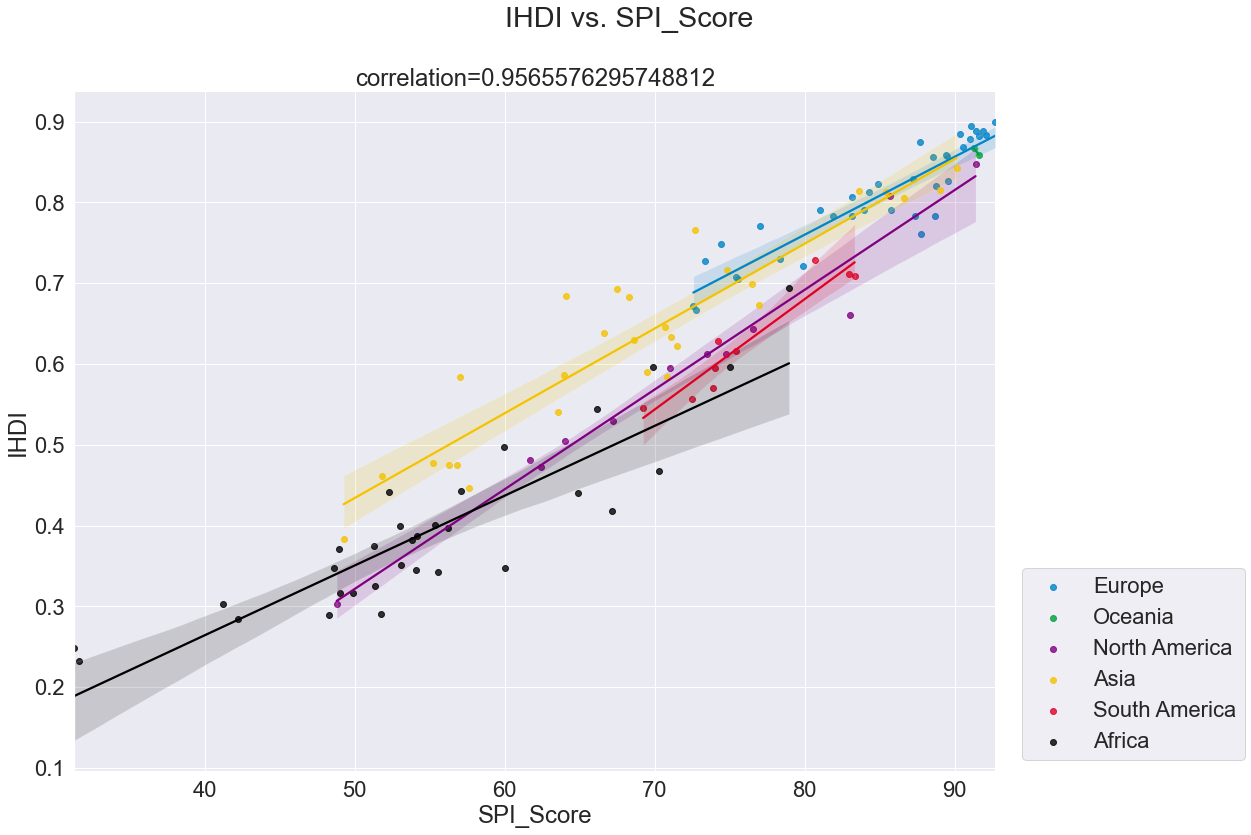

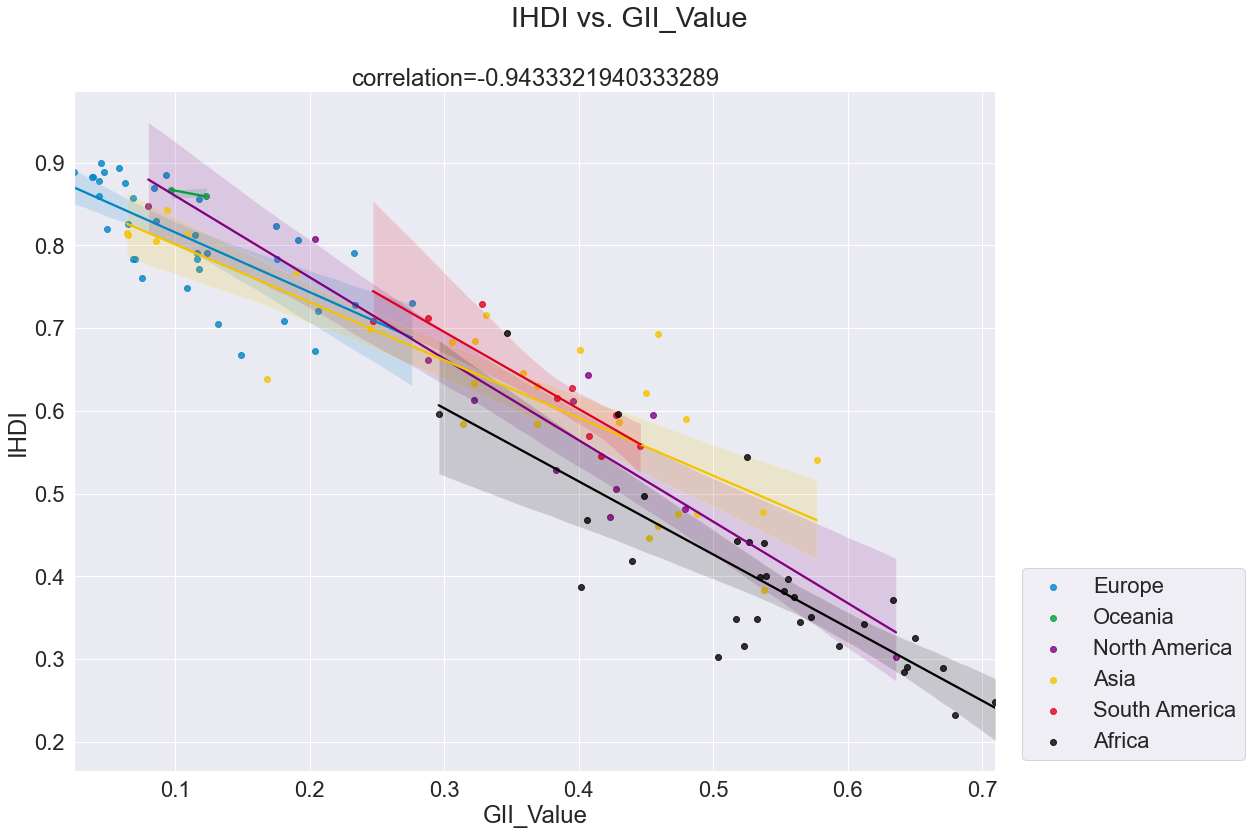

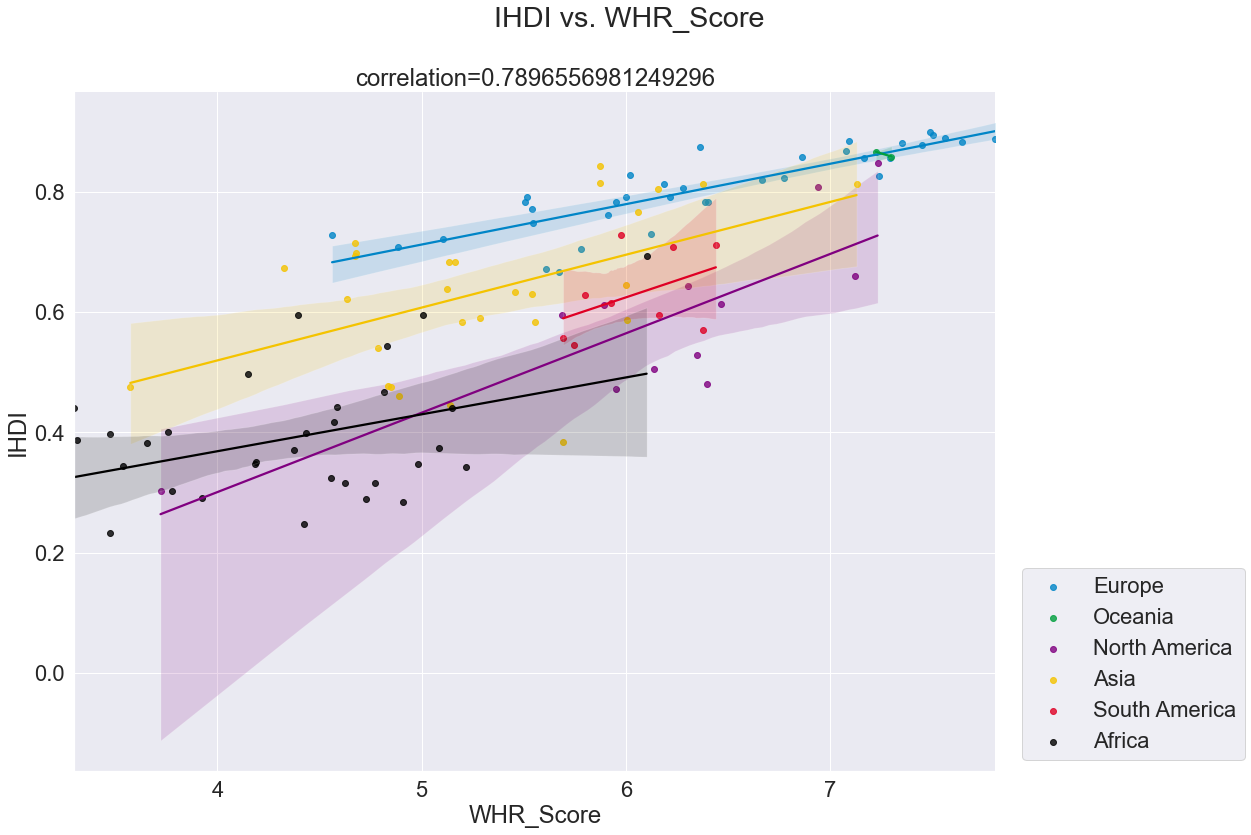

In [31]:
# Make subplots
# fig, axes = plt.subplots(ncols=3, figsize=(20,5))
# plt.subplots_adjust(hspace=0.4)

sns.set(font_scale=2)


# Make empty ps.Series
corr_to_ihdi = pd.Series(dtype='float64')
# Finds correlation between IHDI and [SPI_Score, GII_Value, WHR_Score]
for col in data.columns.values[8:]:
    corr_to_ihdi[col] = data['IHDI'].corr(data[col])
    
# Absolute values of correlation
abs_corr_to_ihdi = corr_to_ihdi.abs().sort_values(ascending=False)
corr_to_ihdi = corr_to_ihdi.loc[abs_corr_to_ihdi.index]

colors = {
    'Europe': '#0085C7', # Blue
    'Asia': '#F4C300',# Yellow
    'Africa': '#000000',# Black
    'Oceania': '#009F3D',# Gree
    'South America': '#DF0024', # Red
    'North America': 'purple'
}


for i, col in enumerate(data.columns.values[8:]):
    lm = sns.lmplot(x=corr_to_ihdi.index.values[i], y='IHDI', hue='Continent', palette=colors, data=data,  fit_reg=True, legend=False)
    fig = lm.fig    
    fig.suptitle(f'IHDI vs. {col}')
    fig.set_size_inches(18, 12)
    a1 = fig.axes[-1]
    a1.set_title('correlation='+str(corr_to_ihdi[i]))
    plt.legend(bbox_to_anchor=(1.15, 0), loc='lower center')
    plt.tight_layout()
                 
plt.show()

### **3. Data Analysis**

At first glance There seems to be a trend where european countries lead in development and the positive results of each index. This is followed in the middle of the plots by north america, asia, and south america. At the end of each trendline lie most of the african countries.

#### **First plot: Development vs Social Progress **

SPI: Social progress index measures the extent to which countries provide for the social and environmental needs of its citizens. The social and environmental factors include wellness (including health, shelter and sanitation), equality, inclusion, sustainability and personal freedom and safety.

Out of all the three plots social progress was the biggest (most correlated) factor with development. Asian countries seemed to be more developed than south american countries but south american countries scored higher on the social index.


#### **Second plot: Development vs Gender Inequality **

GII: Gender inequality index is a composite measure to quantify the loss of achievement within a country due to gender inequality.

Gender inequality also shows a strong correlation with development but not as much as social progress.

#### **Third plot: Development vs **

WHR: The world happiness report is a report that measures happiness based on respondent ratings in their own lives.

Happiness had a more moderate correlation amongst the three to IHDI. Unlike the other two plots, there seemed to be more variance in the continent clusters.